#objectives 
- new data preprocessing and feature engineering 
-- lag time to account for incubation of disease
-- ndvi features are weighted too high in decision tree - new feature from them? remove?
- more elegantly test a few models
- better code to implement gridsearch cv

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso

from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV

from warnings import filterwarnings
filterwarnings('ignore')

In [85]:
train = pd.read_csv('dengue_features_train.csv')
labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('dengue_features_test.csv')

print("train:", train.shape)
print("labels:", labels.shape)
print("test:", test.shape)

train: (1456, 24)
labels: (1456, 4)
test: (416, 24)


In [86]:
both=pd.concat([train, test], axis=0)

In [87]:
both.shape

(1872, 24)

In [88]:
#marker to separate out later on
train['origin']='train'
test['origin']='test'

#combine to jointly do preprocessing
both=pd.concat([train, test], axis=0)
both.fillna(method='ffill', inplace=True)
#new columns for lag time to account for incubation of disease
both['week_start_date']=pd.to_datetime(both['week_start_date'])
both['date_shifted_2wk'] = both['week_start_date'].apply(lambda x: x - pd.DateOffset(weeks=2))
both['date_shifted_1wk'] = both['week_start_date'].apply(lambda x: x - pd.DateOffset(weeks=1))
both['weekofyear_shifted_2wk']=both['weekofyear']-2

In [89]:
both['ndvi_all_directions']=(both['ndvi_ne']+both['ndvi_nw']+both['ndvi_se']+both['ndvi_sw'])/4

In [90]:
def get_ndvi_category(x):
    x=float(x)
    if x < 0.1: return 'water'
    if x >= 0.1 and x <0.2: return 'rock/sand'
    if x >=0.2 and x<0.5 : return 'shrub/grassland'
    if x > 0.6: return 'forest'
    return 'other'

In [91]:
both['ndvi_desc'] = both.ndvi_all_directions.apply(get_ndvi_category)

In [92]:
def c2k(t):
    return t+273.15

In [93]:
feature_in_c_list = ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c', 'station_diur_temp_rng_c']

In [94]:
both.shape

(1872, 30)

In [95]:
for i in feature_in_c_list:
    both[i]=both[i].apply(c2k)

In [101]:
both.shape

(1872, 36)

In [23]:
#which features to keep?
#yourdf.drop(['columnheading1', 'columnheading2'], axis=1, inplace=True)
#df = pd.concat([df, pd.get_dummies(df['YEAR'])], axis=1);

In [100]:
both = pd.concat([both, pd.get_dummies(both['city'])], axis=1)
both = pd.concat([both,pd.get_dummies(both['ndvi_desc'])], axis=1)

In [160]:
columns_keep=[
    #'city',
 #'year',
 #'weekofyear',
 #'week_start_date',
 #'ndvi_ne',
 #'ndvi_nw',
 #'ndvi_se',
 #'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 #'origin',
 #'date_shifted_2wk',
 #'date_shifted_1wk',
 'weekofyear_shifted_2wk',
 'ndvi_all_directions', 
 #'ndvi_desc',
 'iq',
 'sj',
 'other',
 'rock/sand',
 'shrub/grassland',
 'water']

In [21]:
from sklearn.decomposition import PCA

In [104]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features

pca = PCA(n_components=13)
pca.fit(both[columns_keep])

print(pca)
print(pca.explained_variance_ratio_) 

PCA(copy=True, iterated_power='auto', n_components=13, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[  6.89595243e-01   2.41677579e-01   5.50842164e-02   1.01002480e-02
   2.72881557e-03   5.68933558e-04   1.23490850e-04   7.67541455e-05
   3.61333070e-05   8.41179500e-06   1.75373738e-07   3.76659836e-36
   6.85724906e-37]


In [105]:
both.shape

(1872, 36)

In [108]:
# separate it out
train = both[both['origin']=='train']
test = both[both['origin']=='test']
#iq vs sj
iq=train[train['city']=='iq']
sj=train[train['city']=='sj']

In [161]:
model = DecisionTreeRegressor(random_state=0)
X_train=train[columns_keep]
#y_train=labels.pop('total_cases')
X_test=test[columns_keep]
model.fit(X_train, labels['total_cases'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [162]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, labels['total_cases'], cv=10)
scores

array([-2.58827672,  0.02645454, -0.46910909, -1.18992804, -9.91603631,
       -4.4004343 , -1.05197734, -2.30817619, -0.32051751, -0.89088174])

In [163]:
# Including this to remind you that it is necessary to use numpy arrays rather 
# than lists otherwise you will get an error
from sklearn import cross_validation
X_digits = np.array(X_train)
Y_digits = np.array(labels['total_cases'])

scores =cross_val_score(model, X_digits, Y_digits, scoring='neg_mean_absolute_error', cv=10)

# This will print the mean of the list of errors that were output and 
# provide your metric for evaluation
print (scores.mean())
print(scores)

-25.2105243269
[-36.07534247 -51.80136986 -35.88356164 -22.7260274  -26.10273973
 -32.15068493 -18.63448276  -9.13103448  -8.73103448 -10.86896552]


In [164]:
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]

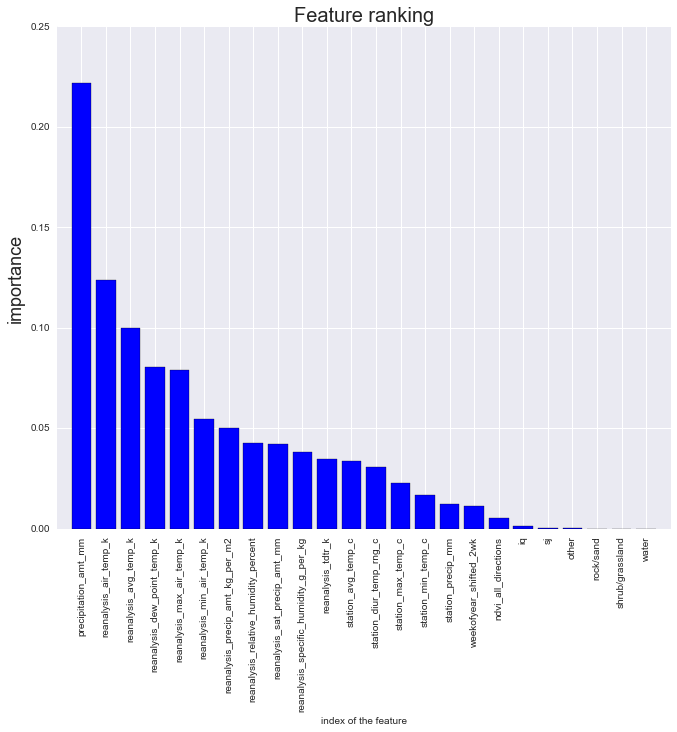

In [165]:
feature_names = X_train.columns

f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X_train.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 10)

In [166]:
y_pred = model.predict(X_test)

In [167]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])
submission.total_cases = np.concatenate([y_pred])
submission['total_cases']=submission['total_cases'].astype(int)
submission.to_csv("submissions/dtr5.csv")

In [ ]:
#should I remove year? probably...

In [ ]:
#perform grid search on the best decision tree so far

In [171]:
param_grid = {"min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              'max_features': ["auto", "sqrt", "log2"]
             
             }

In [172]:
clf = GridSearchCV(DecisionTreeRegressor(), param_grid, n_jobs=4)
clf.fit(X_train, labels['total_cases'])
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

-0.377673275717 {'max_depth': 2, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'min_samples_split': 10}


In [173]:
y_pred=tree_model.predict(X_test)
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])
submission.total_cases = np.concatenate([y_pred])
submission['total_cases']=submission['total_cases'].astype(int)
submission.to_csv("submissions/dt_optimized.csv")